In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, TensorDataset

%matplotlib inline

## 1. Data Extraction

In [2]:
train_dataset = h5py.File('/content/drive/MyDrive/Colab Notebooks/datasets/happy house/train_happy.h5', "r")
train_set_x_orig = torch.tensor(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = torch.tensor(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('/content/drive/MyDrive/Colab Notebooks/datasets/happy house/test_happy.h5', "r")
test_set_x_orig = torch.tensor(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = torch.tensor(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

In [3]:
train_set_x_orig.shape

torch.Size([600, 64, 64, 3])

In [4]:
train_set_y_orig.shape

torch.Size([600])

In [5]:
test_set_x_orig.shape

torch.Size([150, 64, 64, 3])

In [6]:
X_train = train_set_x_orig/255
X_test = test_set_x_orig/255

## 2. Data Loaders

In [7]:
train_dataset = TensorDataset(X_train, train_set_y_orig)
test_dataset = TensorDataset(X_test, test_set_y_orig)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128)

## 3. Model Building

In [9]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    images = images.permute(0,3,1,2)
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  
  def validation_step(self, batch):
    images, labels = batch
    images = images.permute(0,3,1,2)
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss":loss.detach(), "val_acc":acc}

  def validaiton_epoch_end(self, outputs):
    batch_losses = [r['val_loss'] for r in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [r['val_acc'] for r in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, validation loss: {result['val_loss']:.4f}, validation accuracy: {result['val_acc']:.4f}")

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
class HappyHouseModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.ZeroPad2d((3,3)),
        nn.Conv2d(3, 32, kernel_size=7, stride=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(29696, 2)
    )

  def forward(self, x):
    return self.network(x)

In [11]:
model = HappyHouseModel()

In [12]:
model

HappyHouseModel(
  (network): Sequential(
    (0): ZeroPad2d(padding=(3, 3), value=0.0)
    (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=29696, out_features=2, bias=True)
  )
)

In [13]:
for images, labels in train_loader:
  images = images.permute(0,3,1,2)
  print("images.shape: ", images.shape)
  out = model(images)
  print("output.shape: ", out.shape)
  break

images.shape:  torch.Size([128, 3, 64, 64])
output.shape:  torch.Size([128, 2])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 4. Model Training

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validaiton_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):
    model.train()
    train_losses = []
    
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      train_losses.append(loss)
    
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [15]:
evaluate(model, val_loader)

{'val_acc': 0.5266335010528564, 'val_loss': 0.7513042688369751}

In [16]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [17]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 3.0832, validation loss: 1.7888, validation accuracy: 0.6033
Epoch [1], train_loss: 1.2971, validation loss: 0.3645, validation accuracy: 0.8004
Epoch [2], train_loss: 0.7088, validation loss: 1.0812, validation accuracy: 0.7230
Epoch [3], train_loss: 0.3700, validation loss: 0.2300, validation accuracy: 0.8810
Epoch [4], train_loss: 0.2531, validation loss: 0.1920, validation accuracy: 0.9382
Epoch [5], train_loss: 0.1841, validation loss: 0.2799, validation accuracy: 0.8771
Epoch [6], train_loss: 0.1588, validation loss: 0.2602, validation accuracy: 0.8999
Epoch [7], train_loss: 0.1297, validation loss: 0.2551, validation accuracy: 0.8622
Epoch [8], train_loss: 0.1200, validation loss: 0.1477, validation accuracy: 0.9538
Epoch [9], train_loss: 0.0867, validation loss: 0.1463, validation accuracy: 0.9045
Epoch [10], train_loss: 0.0782, validation loss: 0.1596, validation accuracy: 0.9194
Epoch [11], train_loss: 0.0640, validation loss: 0.1359, validation accurac

## 5. Result Visualization

In [18]:
def plot_accuracies(history):
  accuracies = [r['val_acc'] for r in history]
  plt.plot(accuracies, '-x')
  plt.xlabel("No. of Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs No. of epochs")

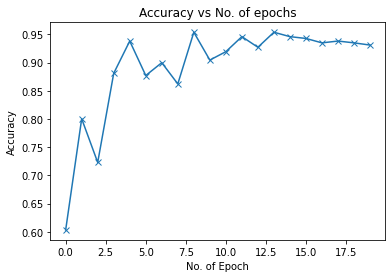

In [19]:
plot_accuracies(history)

In [22]:
def plot_losses(history):
  val_losses = [x['val_loss'] for x in history]
  train_losses = [x['train_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.legend(['Training loss', 'Validation loss'])
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss vs No. of epochs")


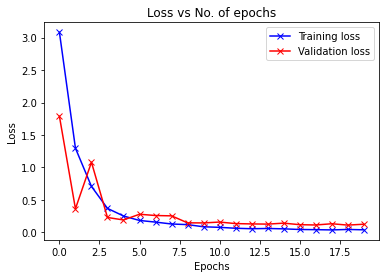

In [23]:
plot_losses(history)

## 6. Test data Prediction

In [24]:
classes

array([0, 1])

In [25]:
def predict_image(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return classes[preds[0].item()]

In [27]:
from PIL import Image

In [52]:
img = Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/happy house/my_image.jpg')

In [53]:
img = img.resize((64,64),Image.ANTIALIAS)

In [54]:
from torchvision import transforms

In [55]:
convert_tensor = transforms.ToTensor()
img = convert_tensor(img)

In [56]:
img.shape

torch.Size([3, 64, 64])

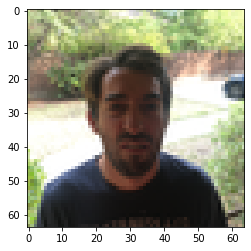

In [57]:
plt.imshow(img.permute(1, 2, 0))

In [58]:
print('Predicted:', predict_image(img, model))

Predicted: 0
